In [47]:
import kagglehub
import numpy as np
import pandas as pd

path = kagglehub.dataset_download("kishan305/la-liga-results-19952020")
print("Path to dataset files:", path)
data_dir = "/root/.cache/kagglehub/datasets/kishan305/la-liga-results-19952020/versions/6"
files = os.listdir(data_dir)
print("Files in directory:", files)


data_file = f"{path}/LaLiga_Matches.csv"

df = pd.read_csv(data_file)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')

df_barca = df[(df['HomeTeam'] == 'Barcelona') | (df['AwayTeam'] == 'Barcelona')].copy()


df_barca['result'] = np.where(
    ((df_barca['HomeTeam'] == 'Barcelona') & (df_barca['FTR'] == 'H')) |
    ((df_barca['AwayTeam'] == 'Barcelona') & (df_barca['FTR'] == 'A')),
    'Win',
    np.where(df_barca['FTR'] == 'D', 'Draw', 'Loss')
)

df_barca['win'] = np.where(df_barca['result'] == 'Win', 1, 0)

df_barca['is_home'] = (df_barca['HomeTeam'] == 'Barcelona').astype(int)

df_barca['opponent'] = df_barca.apply(
    lambda row: row['AwayTeam'] if row['HomeTeam'] == 'Barcelona' else row['HomeTeam'],
    axis=1
)

df_barca['rolling_win_rate'] = df_barca['win'].shift(1).rolling(window=5, min_periods=1).mean()
df_barca['goals_for'] = np.where(df_barca['HomeTeam'] == 'Barcelona', df_barca['FTHG'], df_barca['FTAG'])
df_barca['goals_against'] = np.where(df_barca['HomeTeam'] == 'Barcelona', df_barca['FTAG'], df_barca['FTHG'])

df_barca['goal_diff'] = df_barca['goals_for'] - df_barca['goals_against']

df_barca['rolling_goal_diff'] = df_barca['goal_diff'].shift(1).rolling(window=5, min_periods=1).mean()

df_barca['rolling_goals_for'] = df_barca['goals_for'].shift(1).rolling(window=5, min_periods=1).mean()

df_barca['rolling_goals_against'] = df_barca['goals_against'].shift(1).rolling(window=5, min_periods=1).mean()

df_barca_encoded = pd.get_dummies(df_barca, columns=['opponent', 'Season'], drop_first=True)

feature_cols = ['is_home', 'rolling_win_rate', 'rolling_goal_diff', 'rolling_goals_for', 'rolling_goals_against'] + \
               [col for col in df_barca_encoded.columns if col.startswith('opponent_') or col.startswith('Season_')]


df_barca_encoded = pd.get_dummies(df_barca, columns=['opponent'], drop_first=True)

feature_cols = ['is_home', 'rolling_win_rate'] + [col for col in df_barca_encoded.columns if col.startswith('opponent_')]
X = df_barca_encoded[feature_cols]
y = df_barca_encoded['result']

df_barca_encoded.head()



Path to dataset files: /root/.cache/kagglehub/datasets/kishan305/la-liga-results-19952020/versions/6
Files in directory: ['LaLiga_Matches.csv']


,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,opponent_Sociedad,opponent_Sp Gijon,opponent_Tenerife,opponent_Valencia,opponent_Valladolid,opponent_Vallecano,opponent_Villareal,opponent_Villarreal,opponent_Xerez,opponent_Zaragoza
154,1995-96,1995-02-12,Barcelona,Santander,1,1,D,1.0,1.0,D,...,False,False,False,False,False,False,False,False,False,False
8,1995-96,1995-03-09,Valladolid,Barcelona,0,2,A,0.0,0.0,D,...,False,False,False,False,True,False,False,False,False,False
56,1995-96,1995-04-10,Barcelona,Oviedo,4,1,H,3.0,0.0,H,...,False,False,False,False,False,False,False,False,False,False
112,1995-96,1995-05-11,Barcelona,Salamanca,4,1,H,3.0,0.0,H,...,False,False,False,False,False,False,False,False,False,False
66,1995-96,1995-07-10,Betis,Barcelona,1,5,A,0.0,2.0,A,...,False,False,False,False,False,False,False,False,False,False


In [51]:
X = X.fillna(X.mean())


Training set size: (864, 48)
Testing set size: (216, 48)
Classification Report:
              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00        38
        Loss       0.27      0.12      0.17        25
         Win       0.71      0.93      0.81       153

    accuracy                           0.68       216
   macro avg       0.33      0.35      0.32       216
weighted avg       0.53      0.68      0.59       216



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


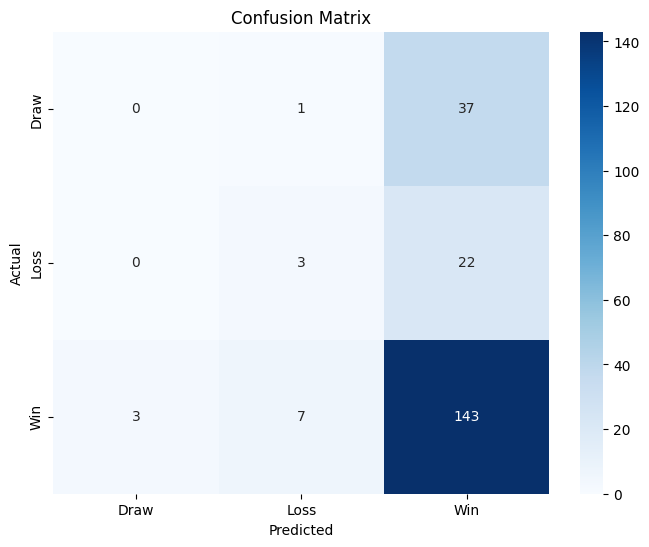

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]



clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)



cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [54]:
def predict_match_outcome(is_home, opponent, model, feature_cols, df_history):

    latest_record = df_history.iloc[-1]

    rolling_win_rate = latest_record['rolling_win_rate']
    rolling_goal_diff = latest_record['rolling_goal_diff']
    rolling_goals_for = latest_record['rolling_goals_for']
    rolling_goals_against = latest_record['rolling_goals_against']

    features = {
        'is_home': is_home,
        'rolling_win_rate': rolling_win_rate,
        'rolling_goal_diff': rolling_goal_diff,
        'rolling_goals_for': rolling_goals_for,
        'rolling_goals_against': rolling_goals_against
    }

    for col in feature_cols:
        if col.startswith("opponent_"):
            features[col] = 1 if col == f"opponent_{opponent}" else 0

    for col in feature_cols:
        if col.startswith("Season_"):
            features[col] = latest_record[col]

    feature_df = pd.DataFrame([features])

    feature_df = feature_df[feature_cols]

    probs = model.predict_proba(feature_df)[0]

    return dict(zip(model.classes_, probs))


result_probabilities = predict_match_outcome(
    is_home=1,
    opponent="Real Madrid",
    model=clf,
    feature_cols=feature_cols,
    df_history=df_barca_encoded
)

formatted_results = {k: f"{v * 100:.2f}%" for k, v in result_probabilities.items()}
print("Predicted probabilities:")
print(formatted_results)


Predicted probabilities:
{'Draw': '24.30%', 'Loss': '16.11%', 'Win': '59.59%'}
